In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopy as gp
from matplotlib import rcParams

In [23]:
abnb_df = pd.read_csv('../data/clean/abnb_clean.gz', low_memory=False)
#pd.read_csv(item, skipinitialspace=True, usecols=copy_cols1, sep=',', low_memory = False)
abnb_df = abnb_df.drop(columns = 'Unnamed: 0')
#abnb_df['last_scraped'] = pd.to_datetime(abnb_df['last_scraped'], infer_datetime_format = True )
abnb_df['year'] = pd.to_datetime(abnb_df['last_scraped']).dt.to_period('Y')
abnb_df['availability_pct'] = abnb_df['availability_365']/365 *100
abnb_df["borough"] = abnb_df["borough"].astype("str")
abnb_df["borough"] = abnb_df["borough"].str.upper()


In [24]:
acs_df = pd.read_csv('../data/clean/acs_estimate.csv', low_memory=False)

In [25]:
zrent_df = pd.read_csv('../data/clean/zrentals.csv', low_memory=False)

In [26]:
zrent_df

,zip_code,state,city,borough,date,mean_rent
0,11385,NY,New York,QUEENS,2015-03-31,2216.568524
1,10467,NY,New York,BRONX,2015-03-31,1303.888993
2,11226,NY,New York,BROOKLYN,2015-03-31,1909.383681
3,11220,NY,New York,BROOKLYN,2015-03-31,1686.421706
4,11207,NY,New York,BROOKLYN,2015-03-31,2113.610448
...,...,...,...,...,...,...
8731,10282,NY,New York,MANHATTAN,2022-10-31,7836.527778
8732,10069,NY,New York,MANHATTAN,2022-10-31,5778.583333
8733,10004,NY,New York,MANHATTAN,2022-10-31,4823.220238
8734,10006,NY,New York,MANHATTAN,2022-10-31,4180.540793


In [27]:
year_count = list(abnb_df.groupby(['year'])['id'].size())
years = ['2015','2016','2017','2018','2019','2020','2021','2022']

In [28]:
abnb_df.keys()

Index(['id', 'last_scraped', 'host_id', 'host_name', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'bedrooms', 'availability_365',
       'calculated_host_listings_count', 'geom', 'zipcode', 'borough', 'year',
       'availability_pct'],
      dtype='object')

In [29]:
def listing_clean(data):
    year_count = list(data.groupby(['year'])['id'].size())
    x=len(years)
    print('Number of NYC Airbnb Listings per Year:')
    for i in range(0,x):
        print('\t'+years[i] +':',year_count[i])
#    print('Number of features in dataset:', data.shape[1])
#    print('Avarage price is : $',round(data.price.mean()))
#    print('Number of hosts/suppliers: ', data.host_id.nunique())
#    print('Number of suburbs: ', data.neighbourhood.nunique())
    return

In [30]:
listing_clean(abnb_df)

Number of NYC Airbnb Listings per Year:
	2015: 33446
	2016: 39133
	2017: 46742
	2018: 48191
	2019: 49773
	2020: 36275
	2021: 36116
	2022: 45827


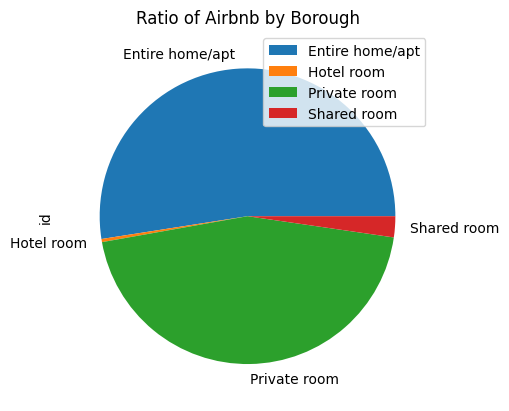

In [31]:
abnb_df.groupby(['room_type']).count().plot(kind='pie', y='id')
#plt.legend(loc = 'lower right')
plt.title('Ratio of Airbnb by Borough')
plt.show()

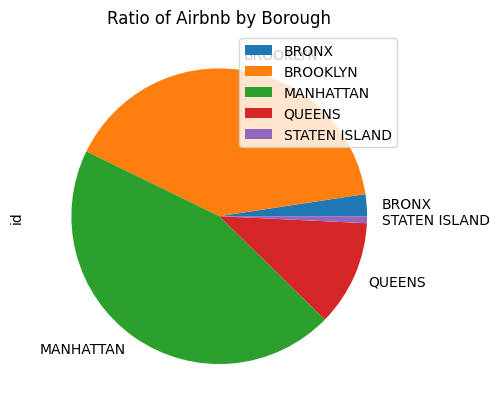

In [32]:
abnb_df.groupby(['borough']).count().plot(kind='pie', y='id')
#plt.legend(loc = 'lower right')
plt.title('Ratio of Airbnb by Borough')
plt.show()

<AxesSubplot: >

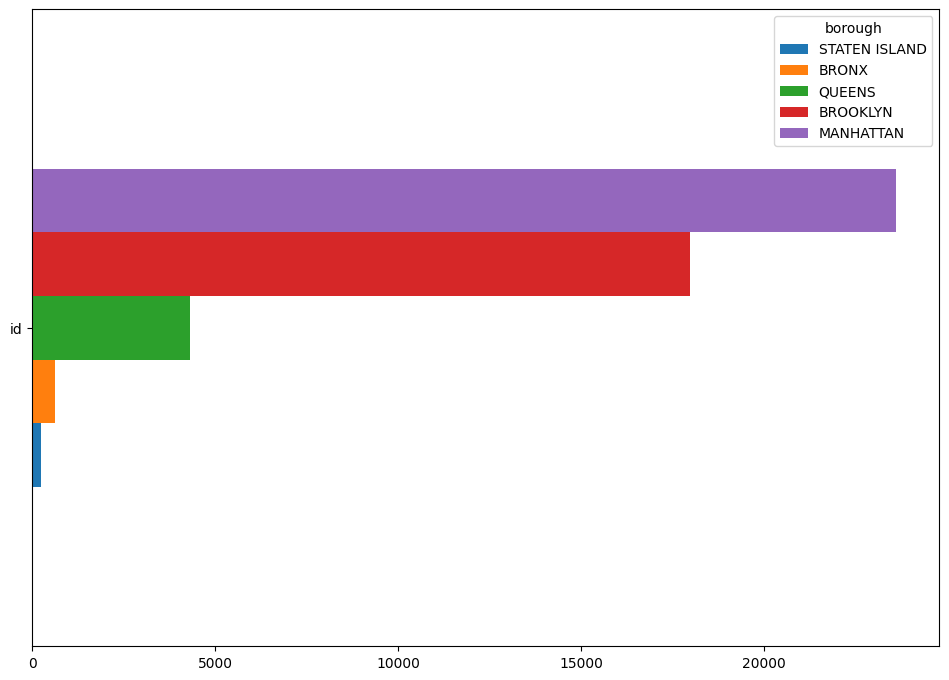

In [77]:
#color display?
abnb_df[abnb_df['year'] == '2017'].groupby(['borough'])['id'].count().to_frame().sort_values('id').T.plot.barh()

In [34]:
abnb_df[abnb_df['host_id']==107434423]

,id,last_scraped,host_id,host_name,neighbourhood,latitude,longitude,room_type,bedrooms,availability_365,calculated_host_listings_count,geom,zipcode,borough,year,availability_pct
11775,20845031,2022-09-07,107434423,Blueground,Kips Bay,40.745723,-73.979862,Entire home/apt,1.0,36,453,"40.74572250000001,-73.9798618",10016,MANHATTAN,2022,9.863014
13169,23264421,2022-09-07,107434423,Blueground,Murray Hill,40.748405,-73.979865,Entire home/apt,1.0,0,453,"40.748405,-73.979865",10016,MANHATTAN,2022,0.000000
13260,23538486,2022-09-07,107434423,Blueground,Murray Hill,40.748410,-73.979870,Entire home/apt,1.0,355,453,"40.74841,-73.97987",10016,MANHATTAN,2022,97.260274
13641,24535218,2022-09-07,107434423,Blueground,Tribeca,40.713833,-74.010242,Entire home/apt,1.0,340,453,"40.713833,-74.010242",10005,MANHATTAN,2022,93.150685
13662,24960138,2022-09-07,107434423,Blueground,Tribeca,40.715790,-74.005870,Entire home/apt,NaN,327,453,"40.71579,-74.00587",10013,MANHATTAN,2022,89.589041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334971,46667694,2020-01-01,107434423,Blueground,Chelsea,40.752450,-73.995090,Entire home/apt,NaN,364,260,"40.75245,-73.99509",11385,QUEENS,2020,99.726027
334972,46667739,2020-01-01,107434423,Blueground,Hell's Kitchen,40.753210,-73.995090,Entire home/apt,NaN,364,260,"40.75321,-73.99509",11374,QUEENS,2020,99.726027
335061,46720587,2020-01-01,107434423,Blueground,Chelsea,40.751810,-73.994950,Entire home/apt,NaN,364,260,"40.75181,-73.99495",10035,MANHATTAN,2020,99.726027
335412,46887704,2020-01-01,107434423,Blueground,Hell's Kitchen,40.767790,-73.991740,Entire home/apt,NaN,364,260,"40.76779,-73.99174",10002,MANHATTAN,2020,99.726027


In [35]:
# What would be a good way to show how many airbnb listings are owned 
# by the same owner and/or managed by the same propoerty management company

In [36]:
abnb_df[abnb_df['host_id']==107434423].groupby(['host_name','year'])['id'].count()

host_name   year
Blueground  2018    174
            2019    254
            2020    256
            2021    283
            2022    442
Georgia     2017      1
Name: id, dtype: int64

In [37]:
abnb_df[abnb_df['host_id']==305240193].groupby(['host_name','year'])['id'].count()

host_name  year
June       2020    170
           2021    380
           2022     23
Name: id, dtype: int64

In [38]:
abnb_df[abnb_df['host_id']==219517861].groupby(['host_name','year'])['id'].count()
#Sonder is a short term rental management company. I wonder why the values dropped off from 2019 to 2020

host_name     year
Sonder (NYC)  2018      1
              2019    307
              2020     37
              2021     47
              2022     60
Name: id, dtype: int64

In [39]:
abnb_df[abnb_df['host_id']==3223938].groupby(['host_name','year'])['id'].count()
# Eugene is someone who works for Settle living a short term rental company offering furnished rooms

host_name  year
Eugene     2020     21
           2021    159
           2022    290
Name: id, dtype: int64

In [40]:
host_test = abnb_df.groupby(['host_id','year'])['id'].count().to_frame().reset_index().sort_values(['id','host_id','year'])

In [41]:
prop_test = host_test[host_test['id']>15].groupby(['host_id','year'])['id'].sum().to_frame().reset_index()
yr_list = list(prop_test['year'].unique())
yr_list.sort()

In [42]:
#This definitely ain't it

# for year in yr_list:
#     prop_test[prop_test['year'] == year].groupby(['host_id'])['id'].sum().plot(kind='pie',y='id')
#     plt.title(year+ ' Test')
#     plt.show()

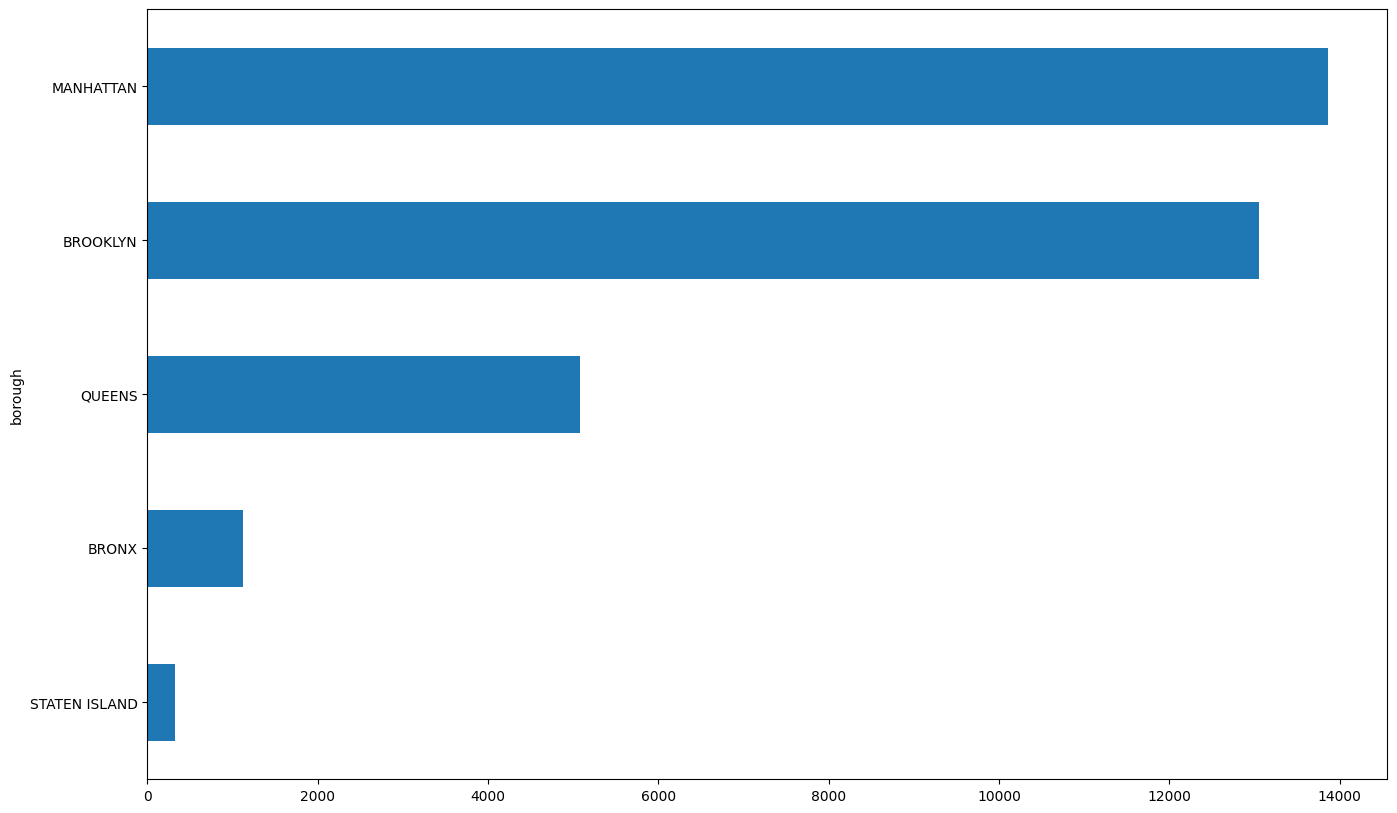

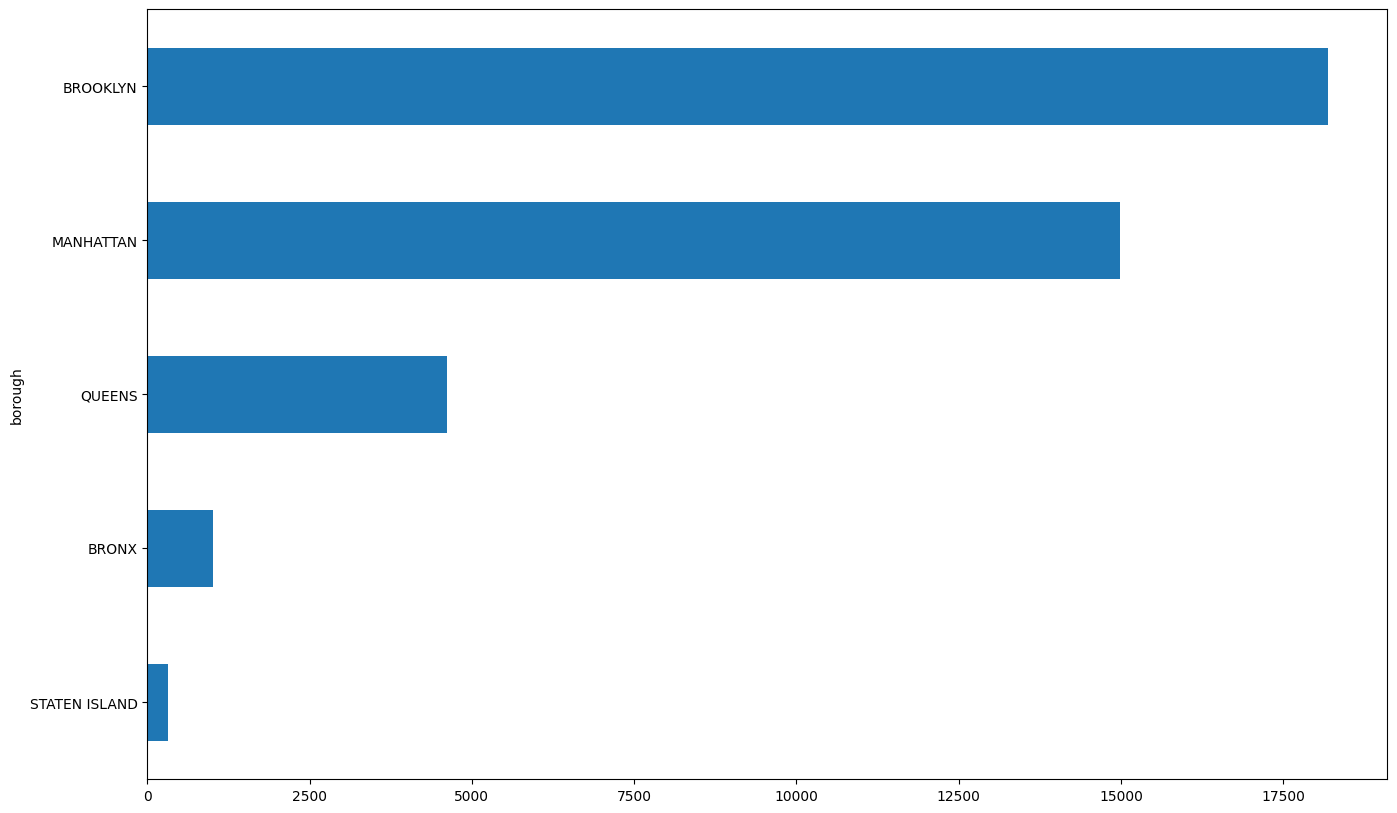

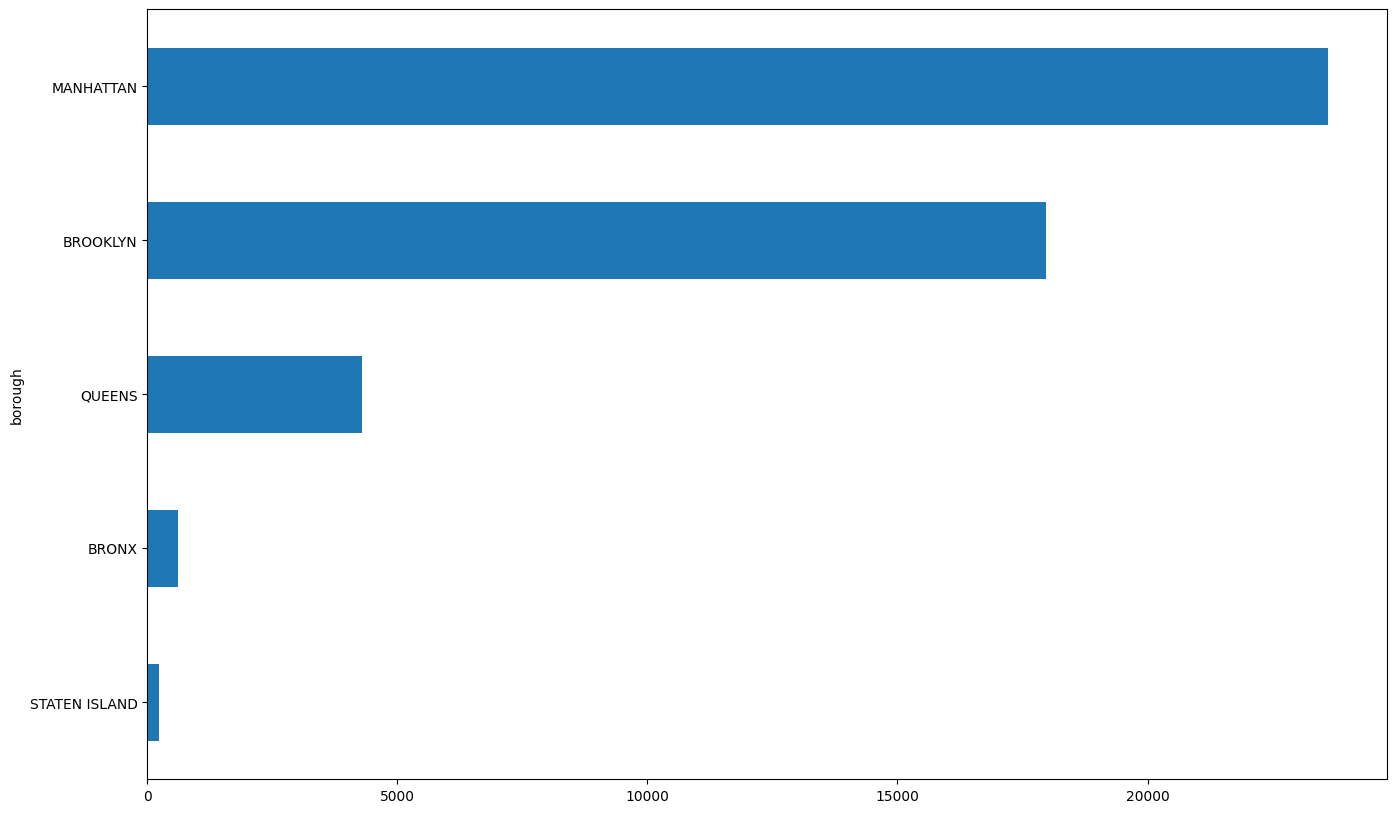

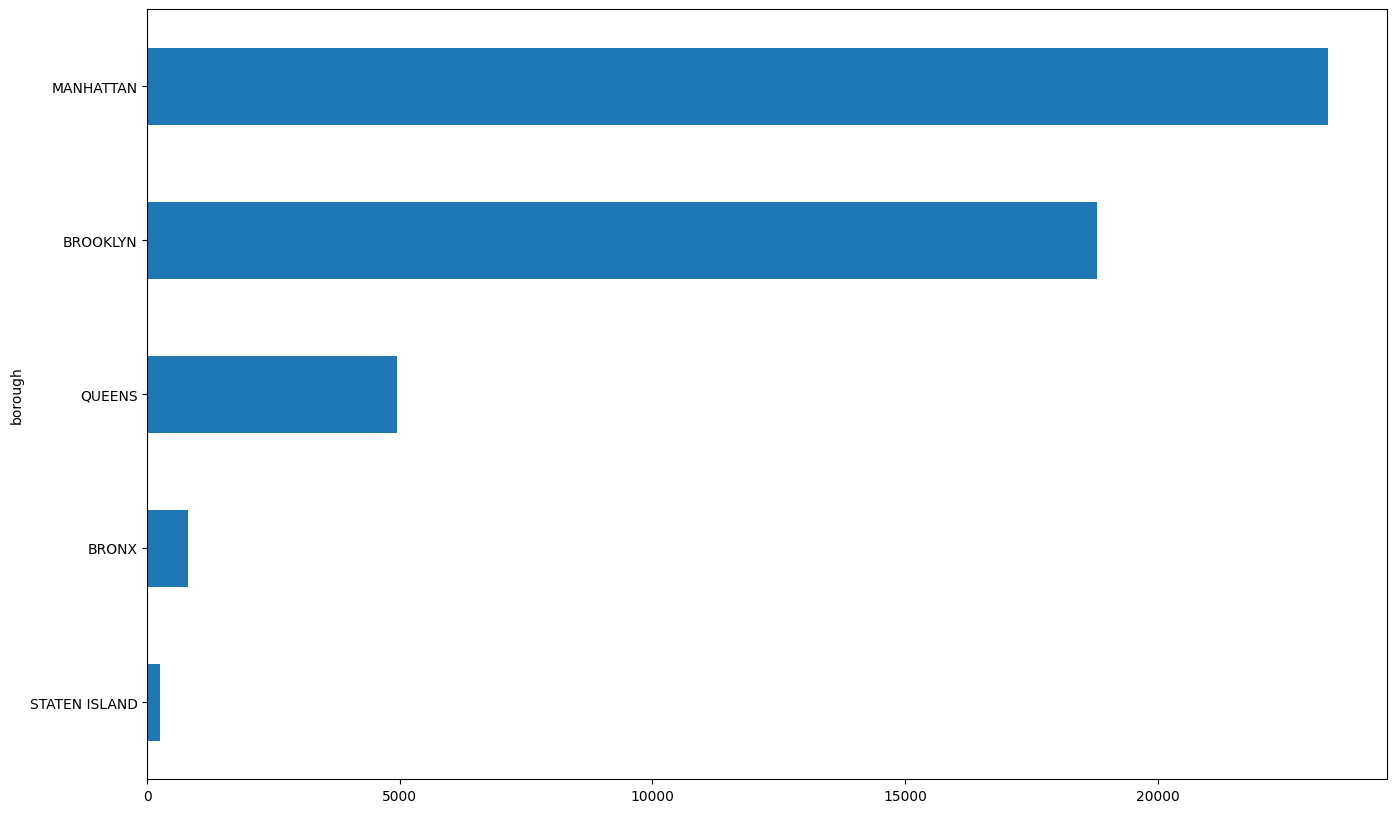

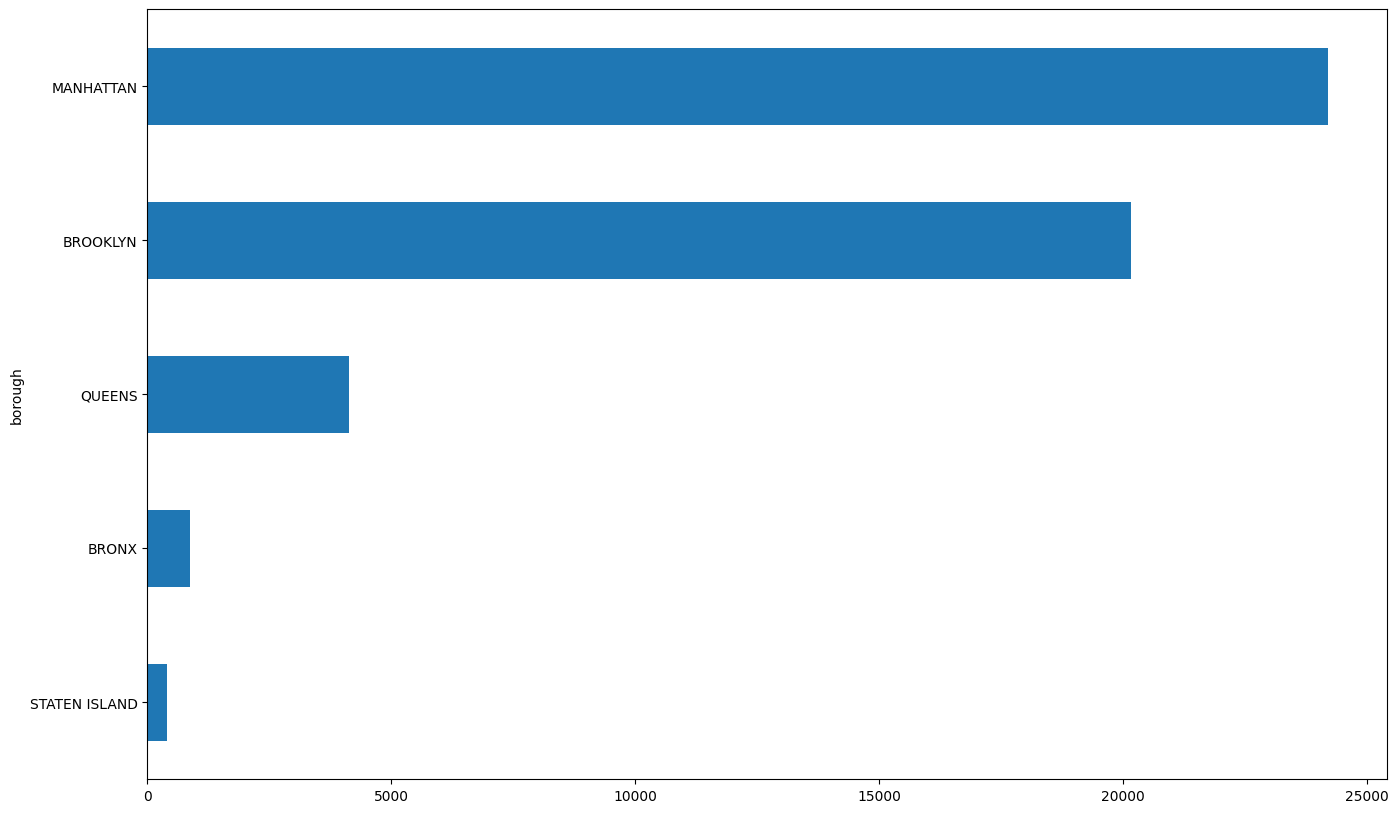

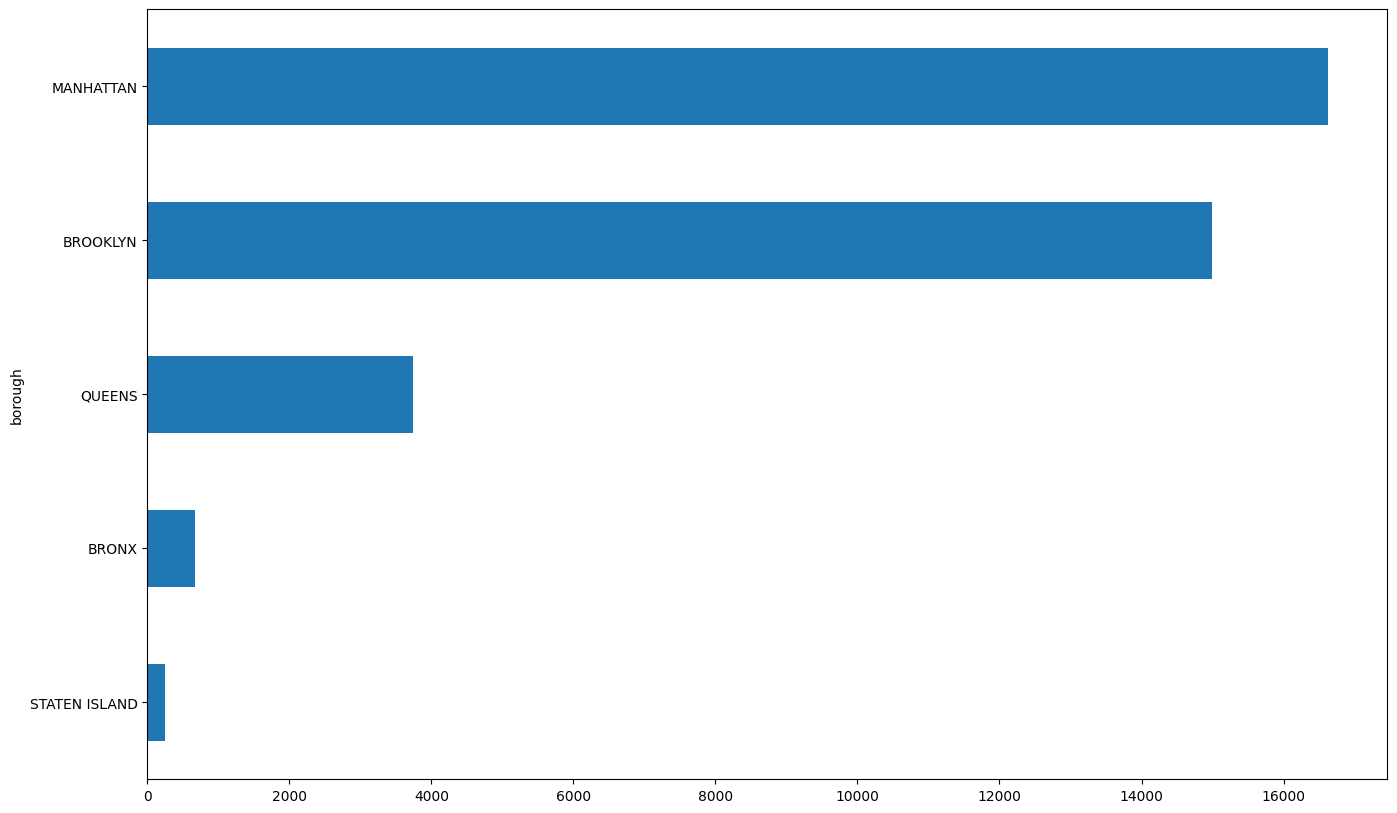

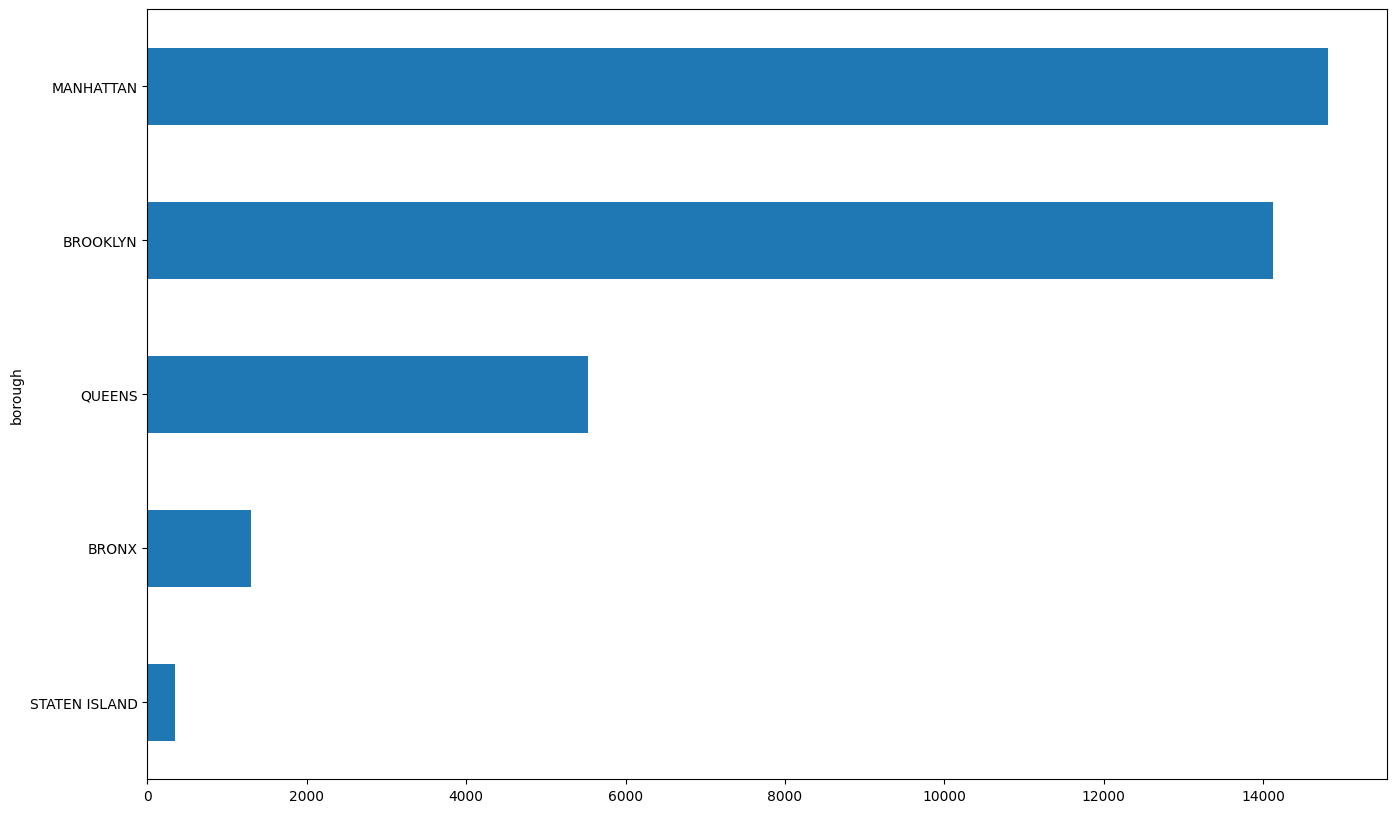

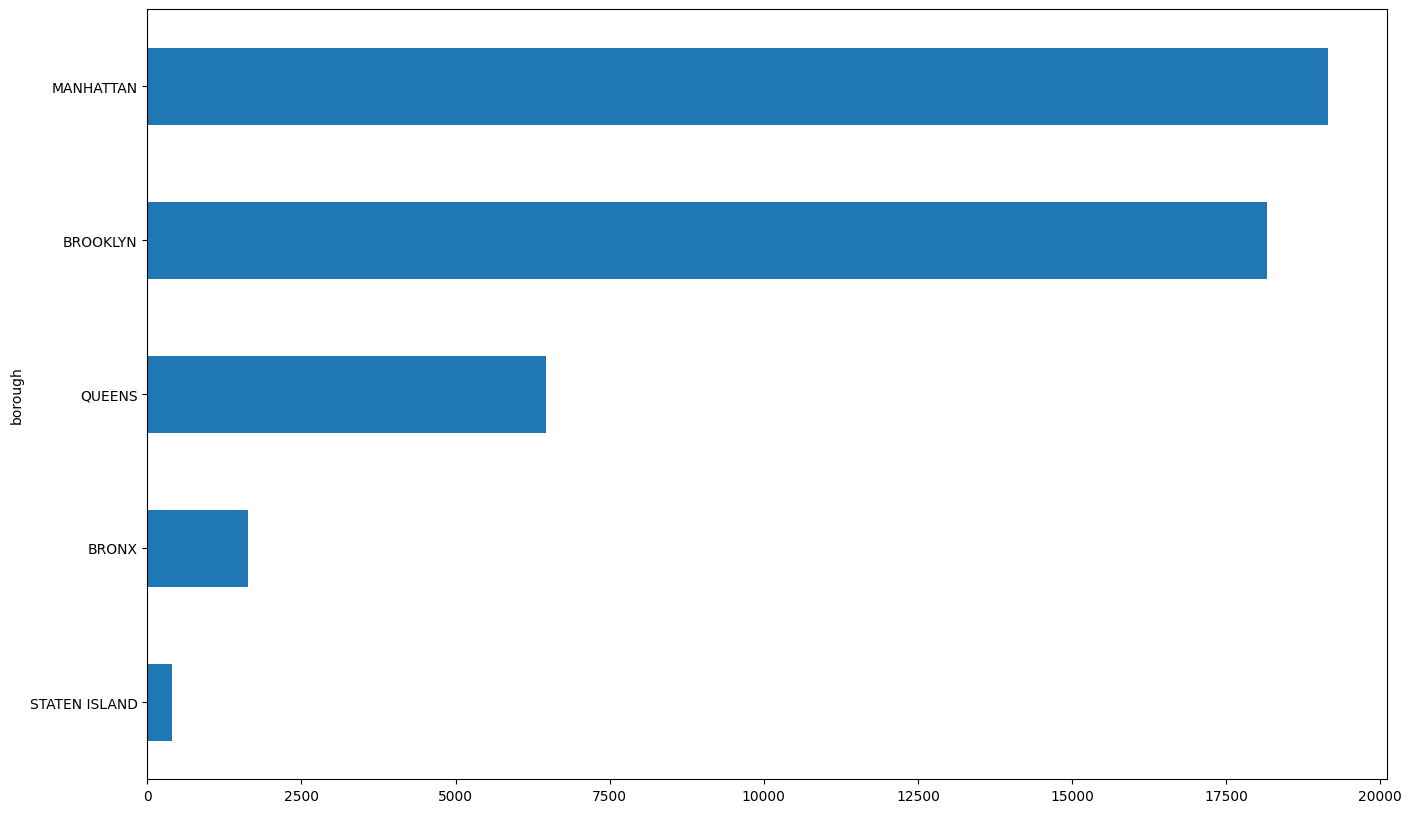

In [43]:
x = len(years)
for i in range(0,x):
    plt.figure(figsize =(16,10))
    abnb_df[abnb_df['year'] == years[i]].groupby(['borough'])['id'].count().sort_values().plot.barh()
    plt.show()

In [44]:
def get_groupby_count(df, groupby_cols, value):
    data = df.groupby(groupby_cols)[value].count().to_frame().reset_index()
    data = data.rename(columns={value:'count'})
    data["year"] = data["year"].apply(lambda x: x.year)
    return data

In [45]:
# Create comparison chart for all boros and NYC based on `value` column
def boro_comparison_line(df, value):
    boro_data = get_groupby_count(df, ['year', 'borough'], value)   
    nyc_data = get_groupby_count(df, ['year'], value)
    nyc_data["borough"] = "NYC"
    
    data = pd.concat([boro_data, nyc_data])

    chart = sns.lineplot(x="year", y="count", hue="borough", data=data)
    chart.axes.set_title("Airbnb count for each borough and NYC".format(value))

In [46]:
#not working
#boro_comparison_line(abnb_df,'id')

In [47]:
# Generate zipcode count
def create_boro_count_chart(df, count_col):
    return get_groupby_count(df, [count_col, "borough", "year"], "id").reset_index(drop=True)

In [48]:
zip_boro_count = create_boro_count_chart(abnb_df, "zipcode")
zip_boro_count.head()

,zipcode,borough,year,count
0,10001,MANHATTAN,2015,350
1,10001,MANHATTAN,2016,666
2,10001,MANHATTAN,2017,418
3,10001,MANHATTAN,2018,491
4,10001,MANHATTAN,2019,275


In [49]:
# HELPER FUNCTION
def map_boro_color(boro):
    boro_color_mapper = {"BRONX": "red", "BROOKLYN": "brown", "MANHATTAN": "blue", "QUEENS": "purple", "STATEN ISLAND": "grey"}
    return boro_color_mapper[boro]

In [71]:
def map_boro_count(data, boro, year):
    data = data[data["borough"]== boro]
    data = data[data["year"] == year]
    print(data)
    color = map_boro_color(boro) 
    order = data.sort_values(by='count').zipcode
    
    rcParams['figure.figsize'] = 11.7,8.27
    chart = sns.barplot(data=data, y="count", x="zipcode", color=color, order=order)
    chart.axes.tick_params(axis='x', rotation=90)
    chart.set_title("{} zipcode count for year {}".format(boro, year))
    return data


In [75]:
zip_boro_count

,zipcode,borough,year,count
0,10001,MANHATTAN,2015,350
1,10001,MANHATTAN,2016,666
2,10001,MANHATTAN,2017,418
3,10001,MANHATTAN,2018,491
4,10001,MANHATTAN,2019,275
...,...,...,...,...
1424,11694,QUEENS,2020,11
1425,11694,QUEENS,2021,43
1426,11694,QUEENS,2022,64
1427,11697,QUEENS,2016,1


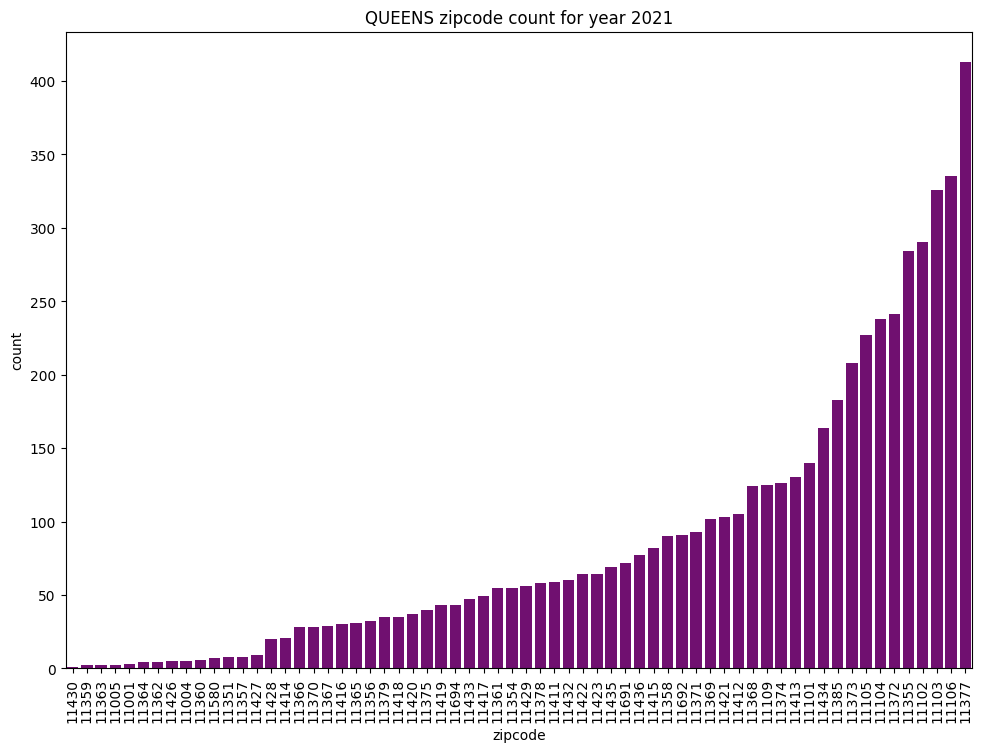

In [76]:
q = map_boro_count(zip_boro_count, "QUEENS", 2021)

In [52]:
abnb_df['year'] = abnb_df['year'].astype(str)
acs_df['year'] = acs_df['year'].astype(str)

In [53]:
acs_df.keys()

Index(['borough', 'total_housing_units', 'occupied_housing_units',
       'vacant_housing_units', '1_room_units', '2_room_units', '3_room_units',
       '4_room_units', '5_room_units', '6_room_units', '7_room_units',
       '8_room_units', '9_room_units', 'unit_median_rooms', 'unit_no_bedrooms',
       'unit_1_bedrooms', 'unit_2_bedrooms', 'unit_3_bedrooms',
       'unit_4_bedrooms', 'unit_5+_bedrooms', 'owner_occupied_units',
       'renter_occupied_units', 'occupants_per_room_<=1',
       'occupants_per_room_1-1.5', 'occupants_per_room_>=1.5',
       'owned_median_value', 'rent_median_value', 'year'],
      dtype='object')

In [54]:
def grouping (df1, df2, group_val, stats):
    plt1 = df1[['year','borough','vacant_housing_units']].sort_values('borough').reset_index(drop=True)
    plt2 =abnb_df.groupby(['borough','year'])['id'].size().to_frame().reset_index()

In [55]:
#x=len(years)
#for i in range(0,x):
#    acs_df[acs_df['year']== year[i]]
plt1 = acs_df[['year','borough','vacant_housing_units']].sort_values('borough').reset_index(drop=True)
plt2 =abnb_df.groupby(['borough','year'])['id'].size().to_frame().reset_index()
pltf = pd.merge(plt1,plt2, on=['borough','year'])
pltf['year']=pltf['year'].astype(int)
pltf = pltf.sort_values(['borough','year'])
pltf = pltf.rename(columns={'id':'abnb_count'})

In [56]:
boro_list = list(pltf['borough'].unique())

<Figure size 700x300 with 0 Axes>

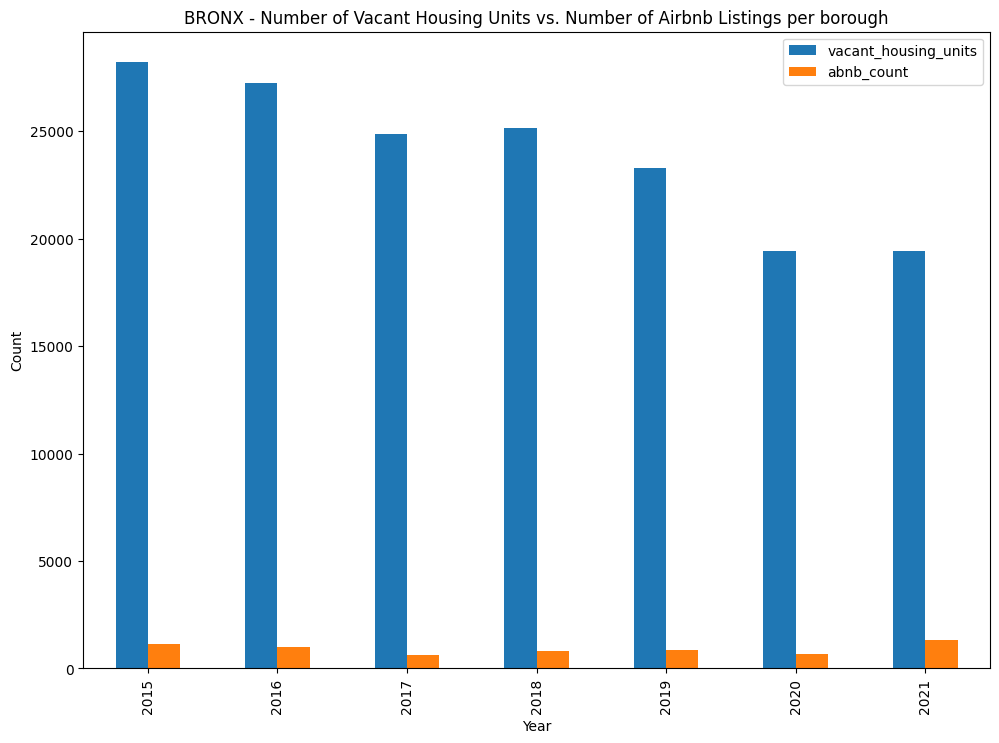

<Figure size 700x300 with 0 Axes>

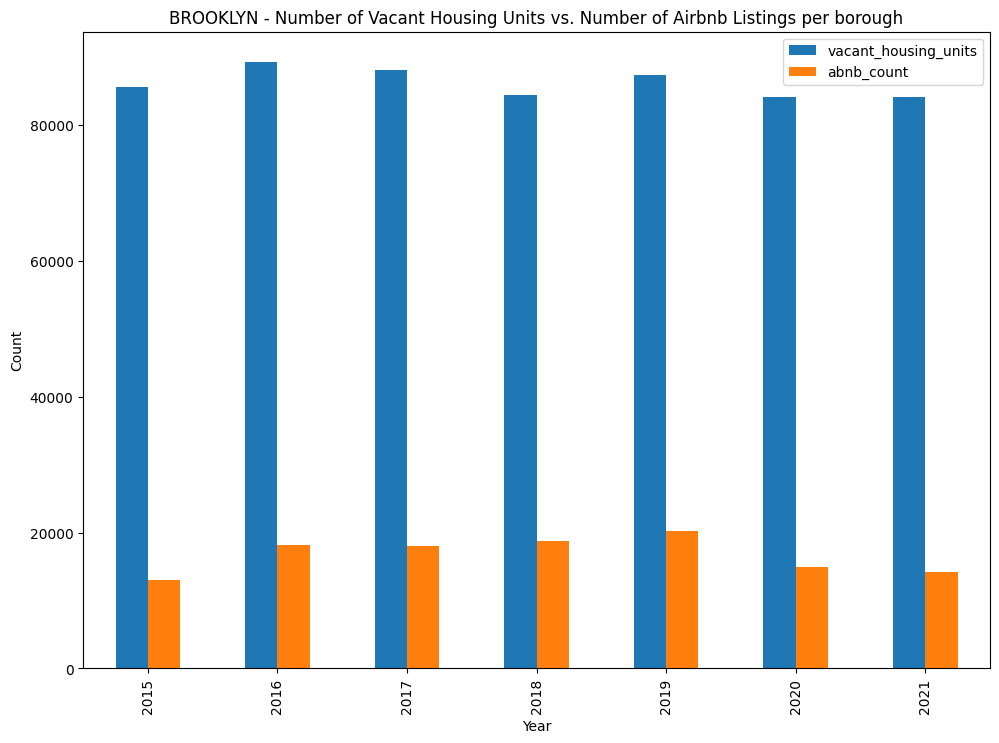

<Figure size 700x300 with 0 Axes>

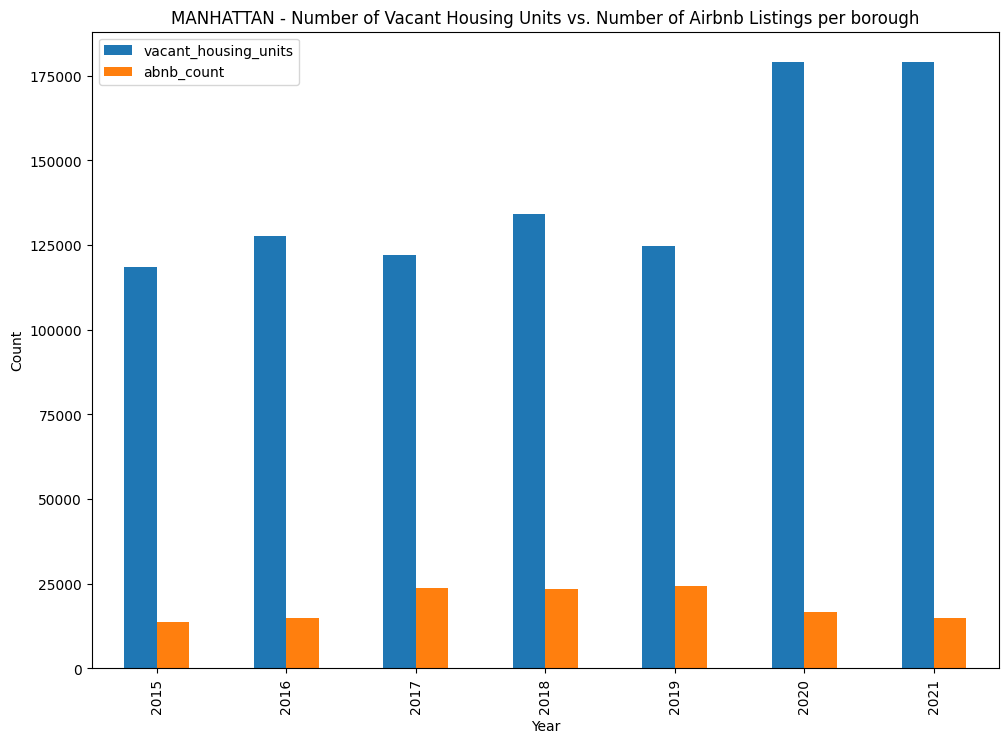

<Figure size 700x300 with 0 Axes>

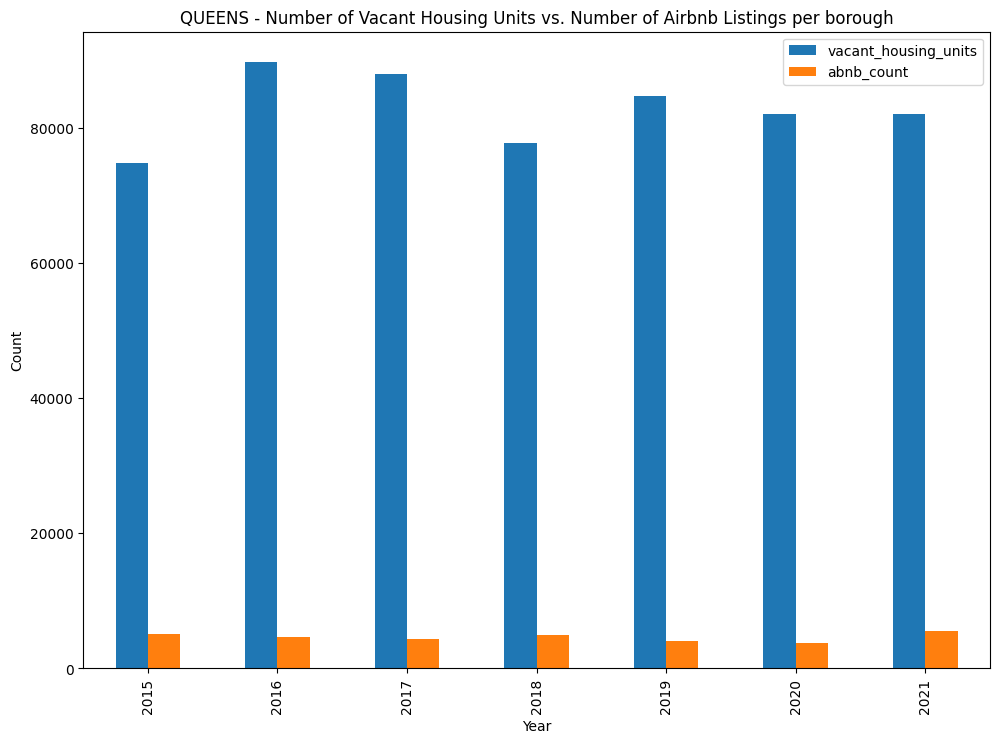

<Figure size 700x300 with 0 Axes>

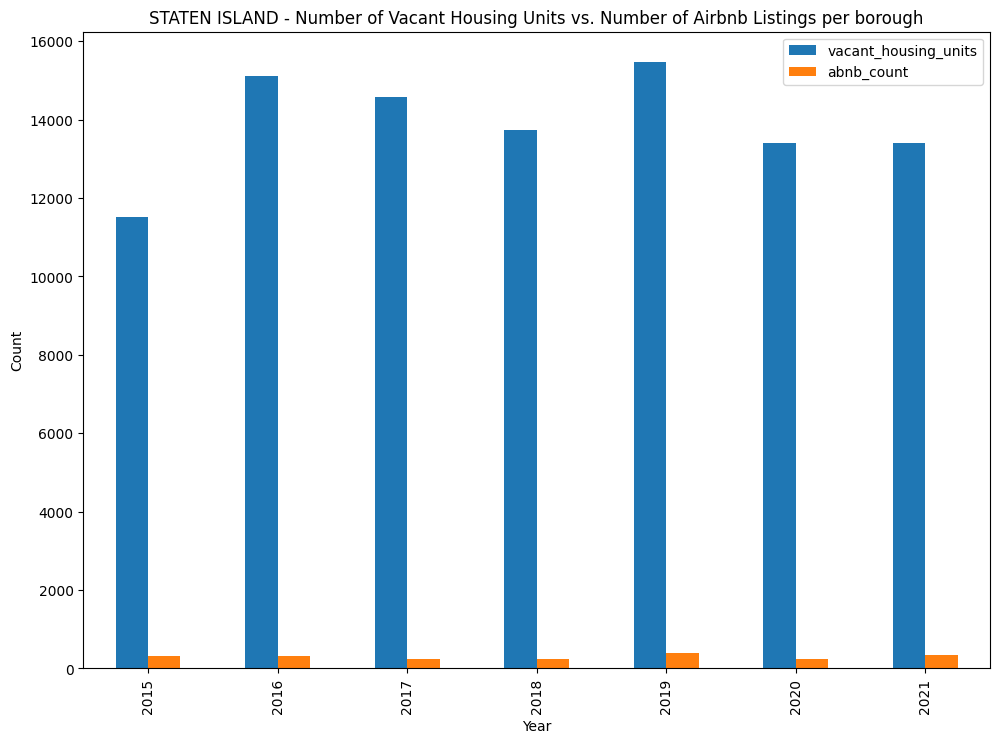

In [57]:
for boro in boro_list:
    plt.figure(figsize =(7,3))
    pltf[pltf['borough'] == boro].plot.bar(x='year')
    plt.xlabel('Year') 
    plt.ylabel('Count') 
    plt.title(boro+' - Number of Vacant Housing Units vs. Number of Airbnb Listings per borough')
    plt.show()
    
#pltf.plot.bar(x='borough')
#plt.xticks(rotation=0)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.show()

In [58]:
plt1 = acs_df[['year','borough','rent_median_value']].sort_values('borough').reset_index(drop=True)
plt2 =abnb_df.groupby(['borough','year'])['id'].size().to_frame().reset_index()
pltf = pd.merge(plt1,plt2, on=['borough','year'])
pltf['year']=pltf['year'].astype(int)
pltf = pltf.sort_values(['borough','year'])
pltf = pltf.rename(columns={'id':'abnb_count'})

<Figure size 700x300 with 0 Axes>

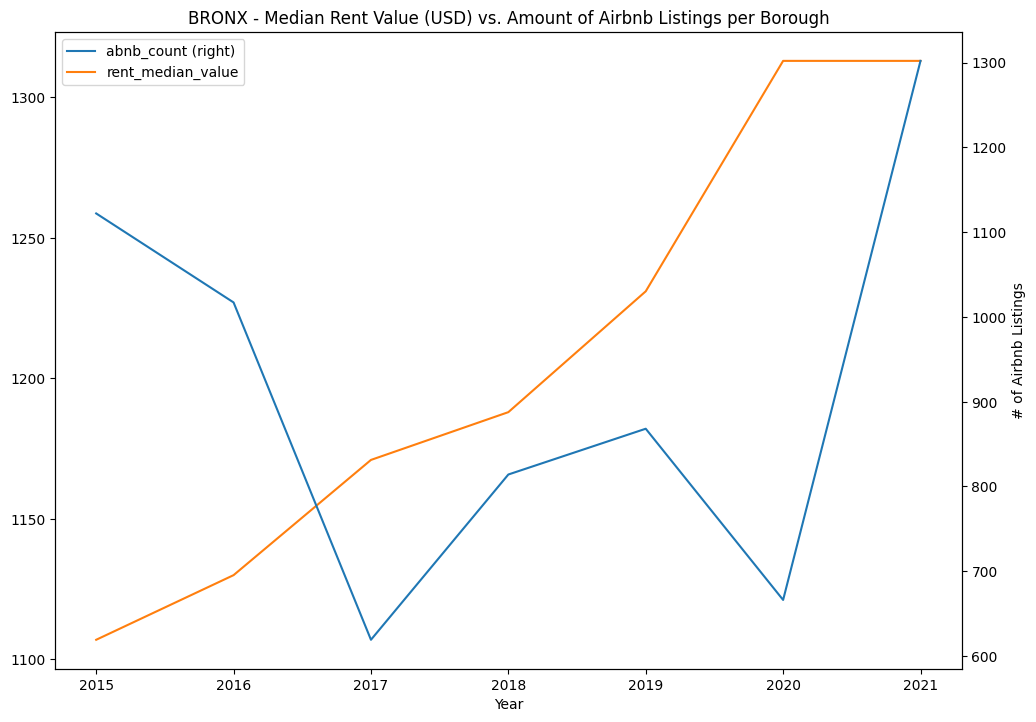

<Figure size 700x300 with 0 Axes>

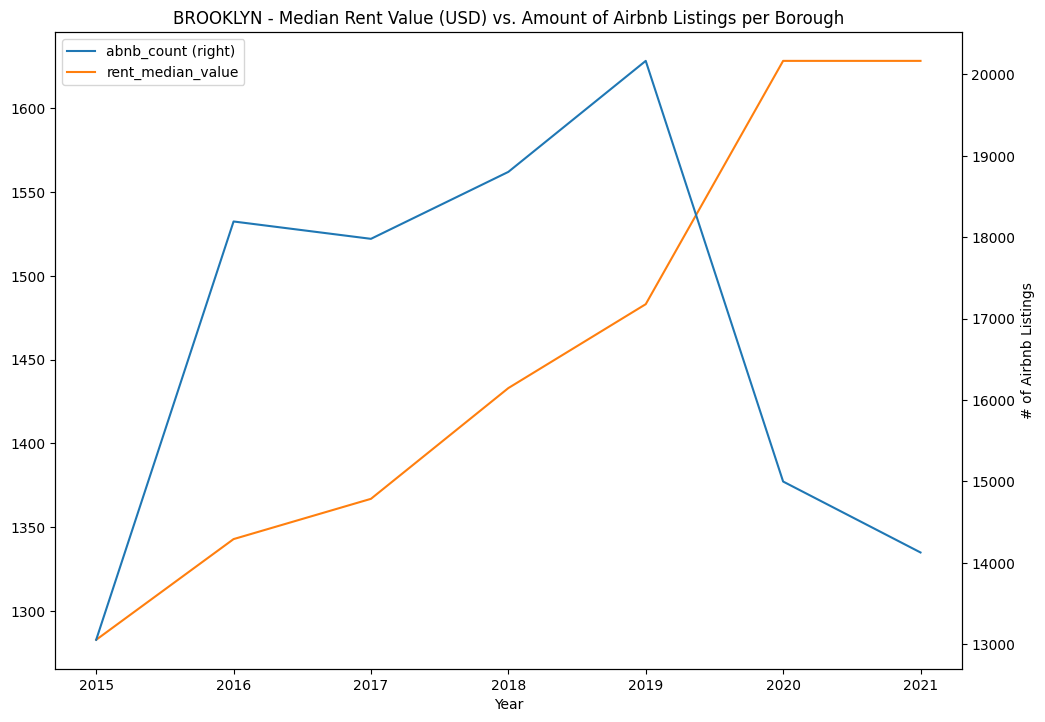

<Figure size 700x300 with 0 Axes>

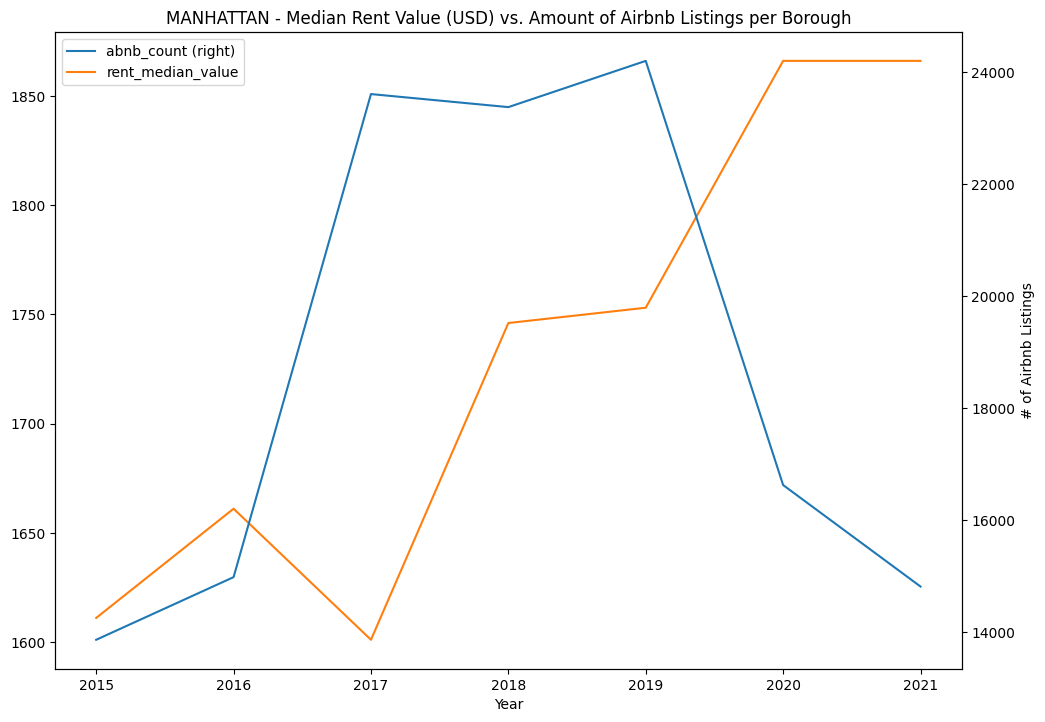

<Figure size 700x300 with 0 Axes>

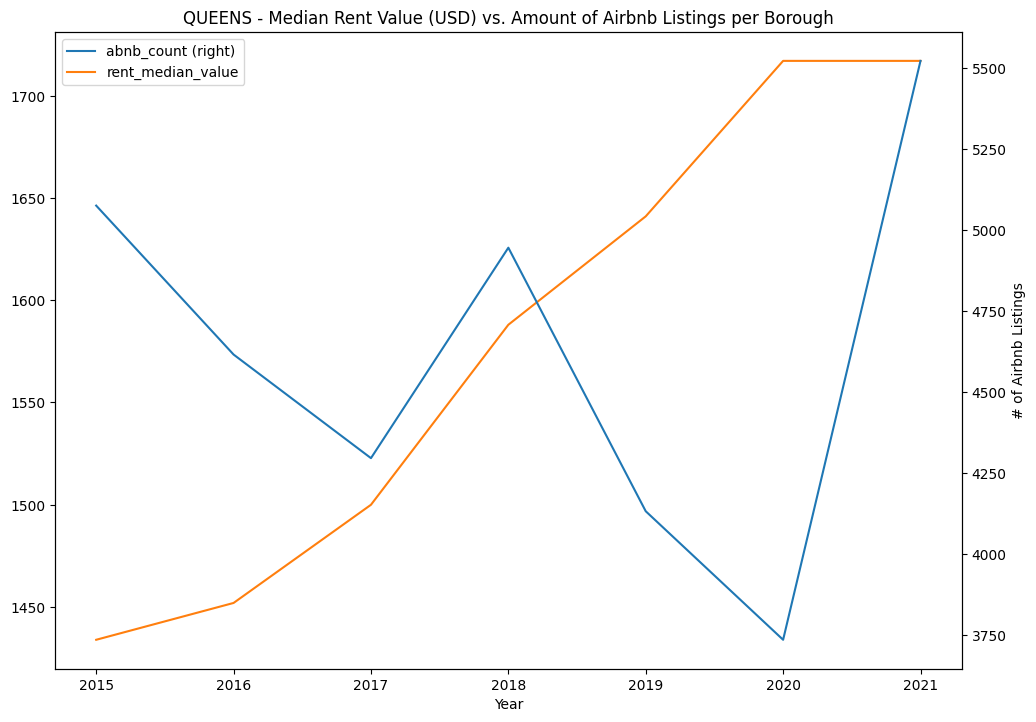

<Figure size 700x300 with 0 Axes>

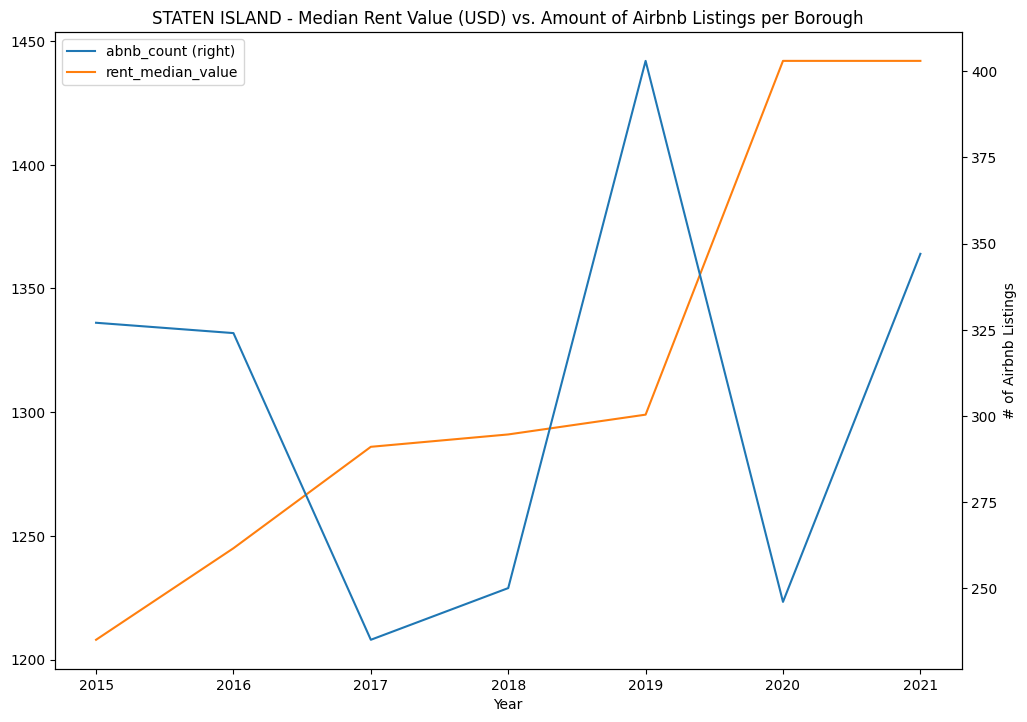

In [59]:
for boro in boro_list:
    plt.figure(figsize =(7,3))
    pltf[pltf['borough'] == boro].plot('year',['abnb_count','rent_median_value'], xlabel='Year'
                                       ,ylabel='Rent Value in dollars', secondary_y='abnb_count')
    plt.ylabel('# of Airbnb Listings') 
    plt.title(boro+' - Median Rent Value (USD) vs. Amount of Airbnb Listings per Borough')
    plt.show()

In [60]:
zrent_df['borough'].sort_values()

5380            BRONX
4486            BRONX
2799            BRONX
5890            BRONX
4936            BRONX
            ...      
6338    STATEN_ISLAND
1691    STATEN_ISLAND
8470    STATEN_ISLAND
6139    STATEN_ISLAND
7477    STATEN_ISLAND
Name: borough, Length: 8736, dtype: object

In [61]:
zrent_df['borough'].replace({'STATEN_ISLAND': 'STATEN ISLAND'})

0          QUEENS
1           BRONX
2        BROOKLYN
3        BROOKLYN
4        BROOKLYN
          ...    
8731    MANHATTAN
8732    MANHATTAN
8733    MANHATTAN
8734    MANHATTAN
8735       QUEENS
Name: borough, Length: 8736, dtype: object

In [62]:
zrent_df['time'] = pd.to_datetime(zrent_df['date']).dt.to_period('Y').astype(str)
zrent_df['borough'] = zrent_df['borough'].replace({'STATEN_ISLAND': 'STATEN ISLAND'})
abnb_df['time'] = pd.to_datetime(abnb_df['last_scraped']).dt.to_period('Y').astype(str)
zrent_df = zrent_df.rename(columns={'zip_code':'zipcode'})

In [63]:
zrent_df.sort_values(['zipcode','time']).head(15)

,zipcode,state,city,borough,date,mean_rent,time
71,10001,NY,New York,MANHATTAN,2015-03-31,3898.696393,2015
153,10001,NY,New York,MANHATTAN,2015-04-30,3945.622620,2015
235,10001,NY,New York,MANHATTAN,2015-05-31,3985.822896,2015
318,10001,NY,New York,MANHATTAN,2015-06-30,4047.122133,2015
401,10001,NY,New York,MANHATTAN,2015-07-31,4043.509711,2015
484,10001,NY,New York,MANHATTAN,2015-08-31,4025.670248,2015
567,10001,NY,New York,MANHATTAN,2015-09-30,4014.194042,2015
650,10001,NY,New York,MANHATTAN,2015-10-31,4039.362019,2015
733,10001,NY,New York,MANHATTAN,2015-11-30,4050.174670,2015
816,10001,NY,New York,MANHATTAN,2015-12-31,4049.849765,2015


In [64]:
plt1 = zrent_df.groupby(['time','borough','zipcode'])['mean_rent'].mean().to_frame().reset_index().sort_values(['zipcode','time'])
plt1

,time,borough,zipcode,mean_rent
33,2015,MANHATTAN,10001,4010.002450
117,2016,MANHATTAN,10001,4022.985795
205,2017,MANHATTAN,10001,3958.378503
295,2018,MANHATTAN,10001,4001.064029
385,2019,MANHATTAN,10001,4145.262809
...,...,...,...,...
438,2019,QUEENS,11435,1708.722415
536,2020,QUEENS,11435,1747.118040
642,2021,QUEENS,11435,1778.252589
778,2022,QUEENS,11435,1904.273478


In [65]:
plt1 = zrent_df.groupby(['time','borough','zipcode'])['mean_rent'].mean().to_frame().reset_index()#.sort_values('borough')
plt2 =abnb_df.groupby(['borough','time','zipcode'])['id'].size().to_frame().reset_index()
pltf = pd.merge(plt1,plt2, on=['borough','time','zipcode'])
#pltf['year']=pltf['year'].astype(int)
pltf = pltf.sort_values(['borough','time'])
pltf = pltf.rename(columns={'id':'abnb_count'})

In [66]:
pltf[pltf['borough']=='BRONX'].head(30)

,time,borough,zipcode,mean_rent,abnb_count
0,2015,BRONX,10457,1301.130802,51
1,2015,BRONX,10458,1412.186633,41
2,2015,BRONX,10461,1320.455377,49
3,2015,BRONX,10462,1372.011858,42
4,2015,BRONX,10463,2072.777743,48
5,2015,BRONX,10467,1358.460170,70
76,2016,BRONX,10457,1432.826664,44
77,2016,BRONX,10458,1531.739651,47
78,2016,BRONX,10461,1388.972758,39
79,2016,BRONX,10462,1475.349176,42


<Figure size 1600x1000 with 0 Axes>

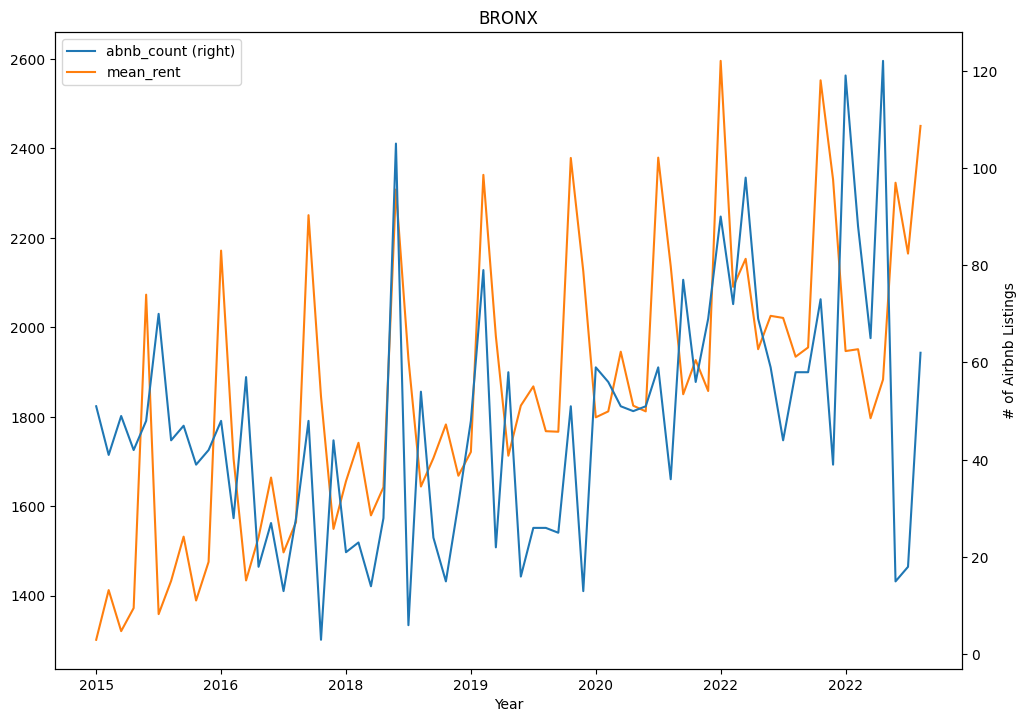

<Figure size 1600x1000 with 0 Axes>

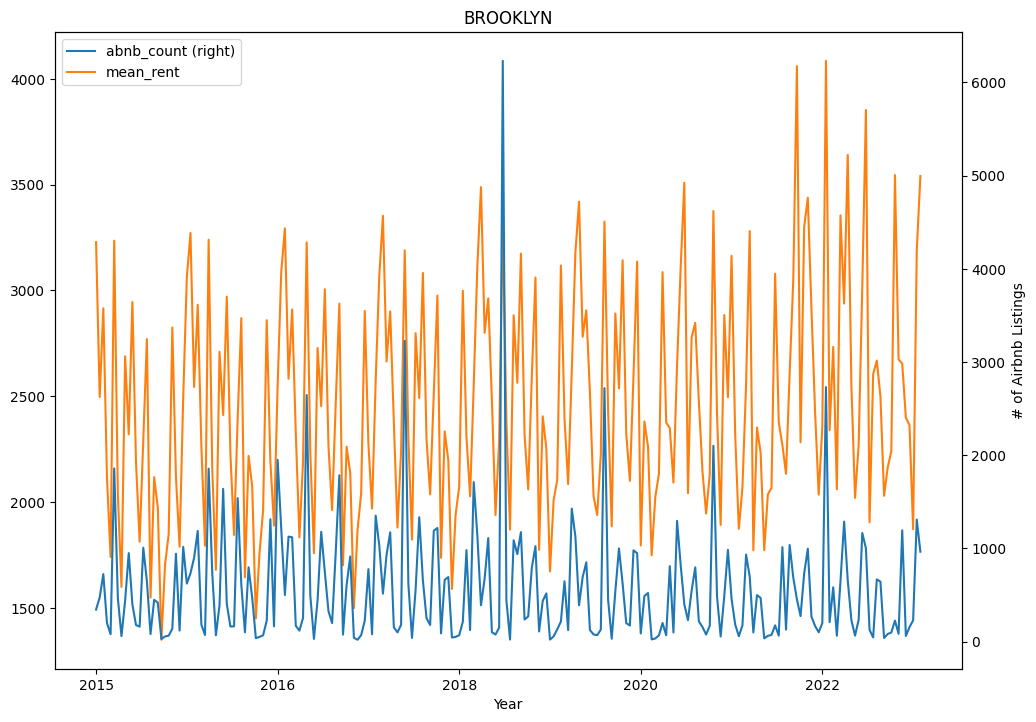

<Figure size 1600x1000 with 0 Axes>

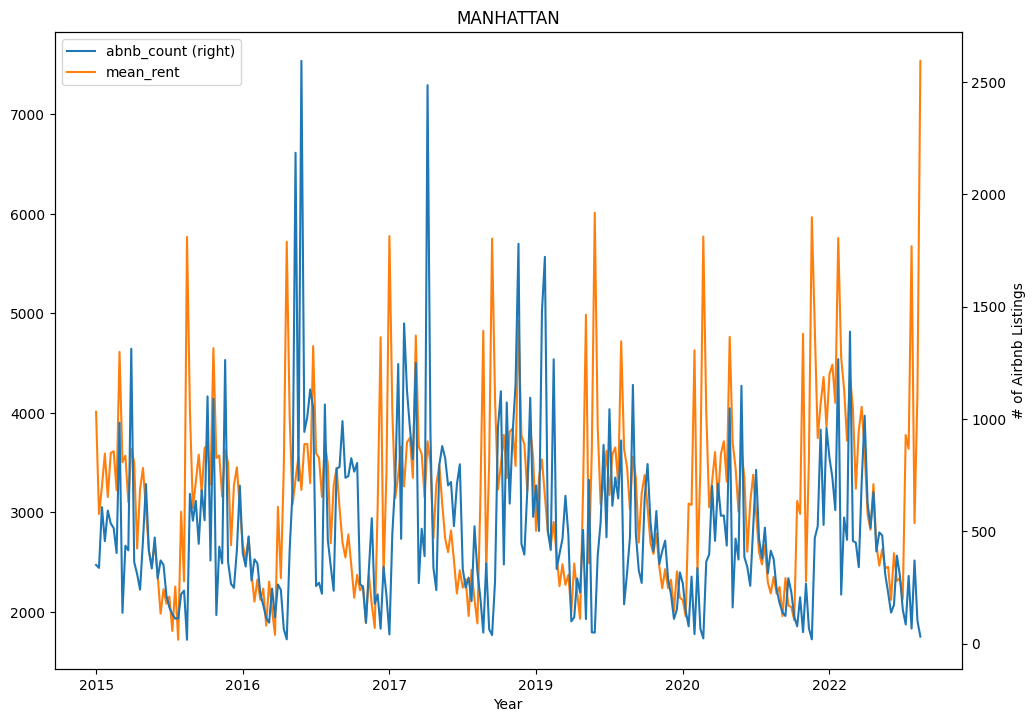

<Figure size 1600x1000 with 0 Axes>

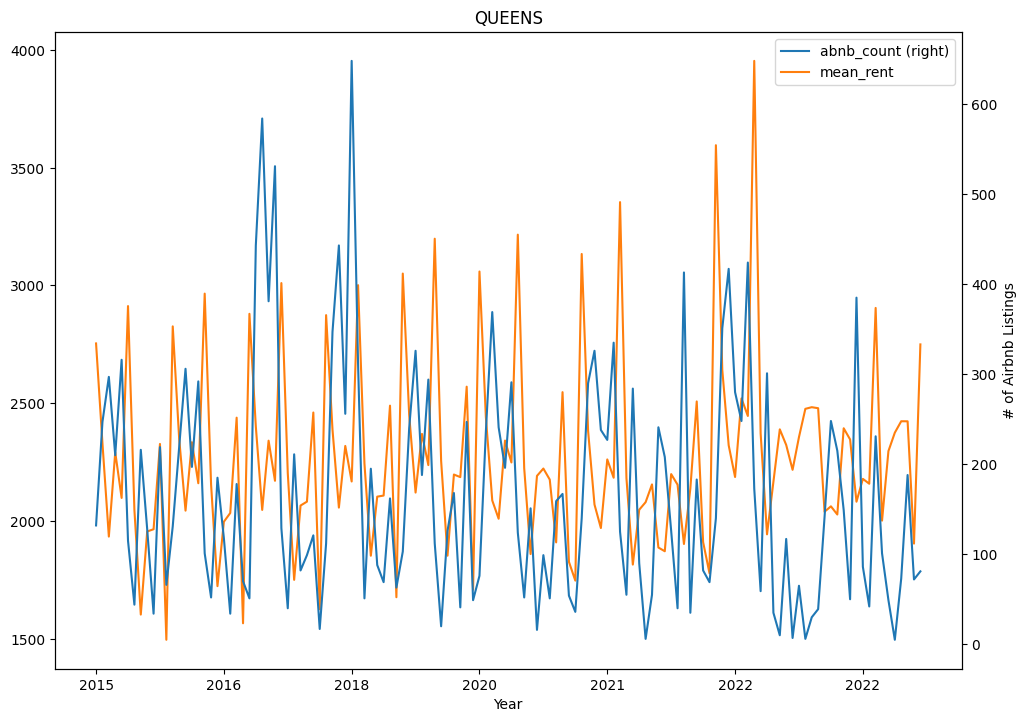

<Figure size 1600x1000 with 0 Axes>

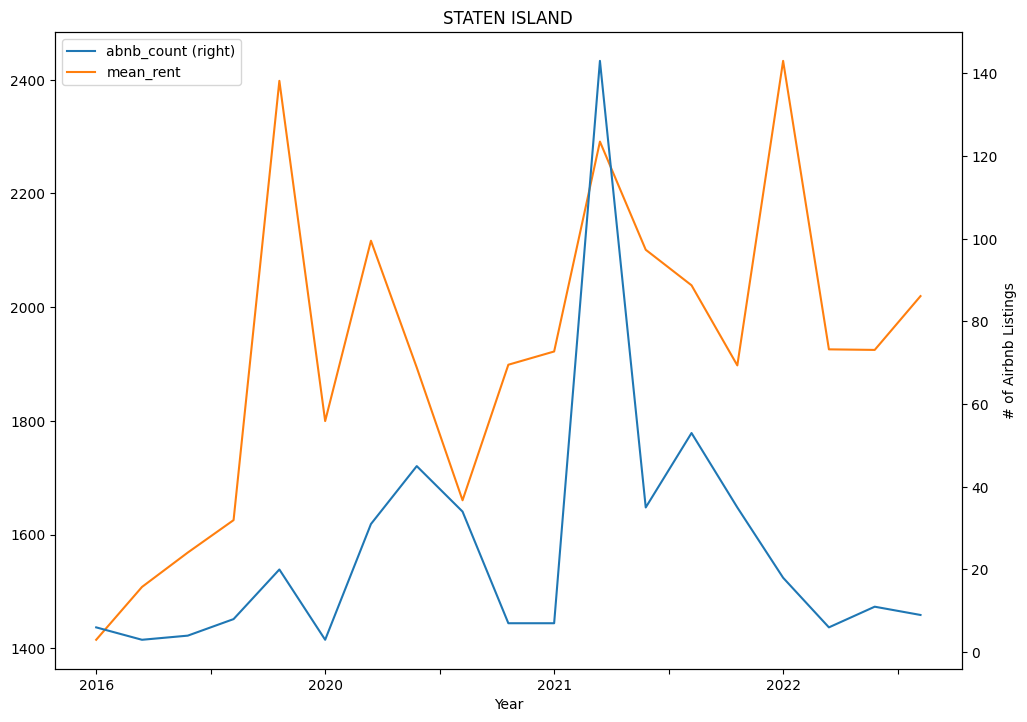

In [67]:
for boro in boro_list:
    plt.figure(figsize =(16,10))
    pltf[pltf['borough'] == boro].plot('time',['abnb_count','mean_rent'], xlabel='Year'
                                       ,ylabel='Mean Rent Value in dollars', secondary_y='abnb_count')
    plt.ylabel('# of Airbnb Listings') 
    plt.title(boro)
    plt.show()

In [68]:
abnb_df

,id,last_scraped,host_id,host_name,neighbourhood,latitude,longitude,room_type,bedrooms,availability_365,calculated_host_listings_count,geom,zipcode,borough,year,availability_pct,time
0,2539,2022-09-07,2787,John,Kensington,40.64529,-73.97238,Private room,1.0,356,9,"40.64529,-73.97238",11218,BROOKLYN,2022,97.534247,2022
1,5121,2022-09-07,7356,Garon,Bedford-Stuyvesant,40.68535,-73.95512,Private room,1.0,335,2,"40.68535,-73.95512",11238,BROOKLYN,2022,91.780822,2022
2,45910,2022-09-07,204539,Mark,Ridgewood,40.70309,-73.89963,Entire home/apt,5.0,365,6,"40.70309,-73.89963",11385,QUEENS,2022,100.000000,2022
3,5136,2022-09-07,7378,Rebecca,Sunset Park,40.66265,-73.99454,Entire home/apt,2.0,179,1,"40.66265,-73.99454",11215,BROOKLYN,2022,49.041096,2022
4,45935,2022-09-07,204586,L,Mott Haven,40.80635,-73.92201,Private room,1.0,83,1,"40.80635,-73.92201",10454,BRONX,2022,22.739726,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335498,46937371,2020-01-01,27181542,Jt,Kips Bay,40.73961,-73.97971,Entire home/apt,NaN,180,15,"40.73961,-73.97971",11217,BROOKLYN,2020,49.315068,2020
335499,46937954,2020-01-01,287807769,Allen,Upper West Side,40.78061,-73.98514,Entire home/apt,NaN,83,1,"40.78061,-73.98514",11226,BROOKLYN,2020,22.739726,2020
335500,46938514,2020-01-01,303319010,Naiomy,East Harlem,40.80054,-73.93340,Shared room,NaN,176,1,"40.80054,-73.9334",11226,BROOKLYN,2020,48.219178,2020
335501,46938537,2020-01-01,3351317,Clara,Kips Bay,40.74033,-73.98242,Entire home/apt,NaN,83,3,"40.74033,-73.98242",10115,MANHATTAN,2020,22.739726,2020


In [69]:
def get_boro_top_zipcodes(df, boro, year):
    zipcode_count = abnb_df.groupby(["zipcode", "borough", "year"])["id"].count().to_frame().reset_index()
    zipcode_count = zipcode_count.rename(columns={"id": "count"})
    zipcode_sorted = zipcode_count[["zipcode", "borough", "year", "count"]].sort_values(by=["count"], ascending=False)
    zipcode_grouped = zipcode_sorted.groupby(["year"])
    print(zipcode_grouped)

In [70]:
get_boro_top_zipcodes(abnb_df, "BRONX", 2019)